We often need to cluster nodes together. 
There are two main cases: 1. clustering of the graph itself, and 2. clustering
of data points based on some property. Such a case is for instance needed when 
clustering neurons based on the similarity of their input-output properties.

This notebooks aims at comparing implemented methods.

# I. Clustering of the graph itself

# II. Clustering of data points based on some property
Example for the beanchmarking: cluster motor neurons in T3 based on their cosine
similarity in terms of inputs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import specific_neurons.mdn_helper as mdn_helper
import specific_neurons.motor_neurons_helper as mns_helper

In [2]:
full_VNC = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)
VNC = full_VNC.get_connections_with_only_traced_neurons()
motor_neurons = mns_helper.get_leg_motor_neurons(VNC, leg="h", side="RHS")

Loaded VNC Connections object with MDNs split by neuropil.
Attribute status:string not found in the graph. Adding it.
Attribute class:string not found in the graph. Adding it.


### A. hierarchical with matrix traverse

In [3]:
# Restricting
cmatrix_1 = VNC.get_cmatrix(type_="unnorm")
premotor_neurons = cmatrix_1.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
cmatrix_1.restrict_nodes(nodes)

# Clustering
(
    clustered_cmatrix_1, # clustered similarity matrix as cmatrix object
    uid_clusters_1, # list of lists of uids in each cluster
    index_clusters_1, # list of lists of indices in each cluster matching the clustered cmatrix
) = cmatrix_1.detect_clusters(
    distance="cosine",
    method="hierarchical",
    cutoff=0.5,
    cluster_size_cutoff=2,
    cluster_data_type="uid",
    cluster_on_subset = motor_neurons,
)

/home/hurtak/vnc_networks/vnc_networks/cmatrix.py:694: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(matrix_, method="ward")
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/matrixlib/defmatrix.py:446: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[256002, 87043, 308234, 233483, 138255, 179215, 97296, 179220, 170008, 164888, 179226, 167966, 174115, 161827, 253998, 2098, 151607, 81975, 225340, 8255, 60483, 361554, 351315, 348246, 218198, 156766, 219231, 189539, 192623, 21619, 328824, 150650, 281729, 325762, 199809, 176260, 158851, 301191, 109705, 8333, 347278, 118928, 228502, 157850, 295067, 193697, 341157, 263334, 257193, 350380, 364717, 128172, 155823, 235700, 350390, 317623, 51385, 20666, 357566, 356543, 268495, 255184, 63698, 326866, 264405, 360668, 120030, 28896, 361696, 177376, 282852, 6372, 226537, 302315, 304366, 299249, 174322, 201969, 145656, 139514, 251, 318717, 200961, 182537, 128269, 160015, 62744, 47391, 104745, 123178, 275759, 208190, 112972, 108878, 313690, 275804, 308578, 125284, 62823, 221544, 178540, 203122, 315763, 150900, 76149, 74102, 21878, 272764, 251262, 297343, 196994, 244099, 28035, 7556, 145799, 115081, 280972, 152976, 268697, 254364, 168348, 12703, 294308, 13734, 332200, 364973, 287150, 148912, 231857

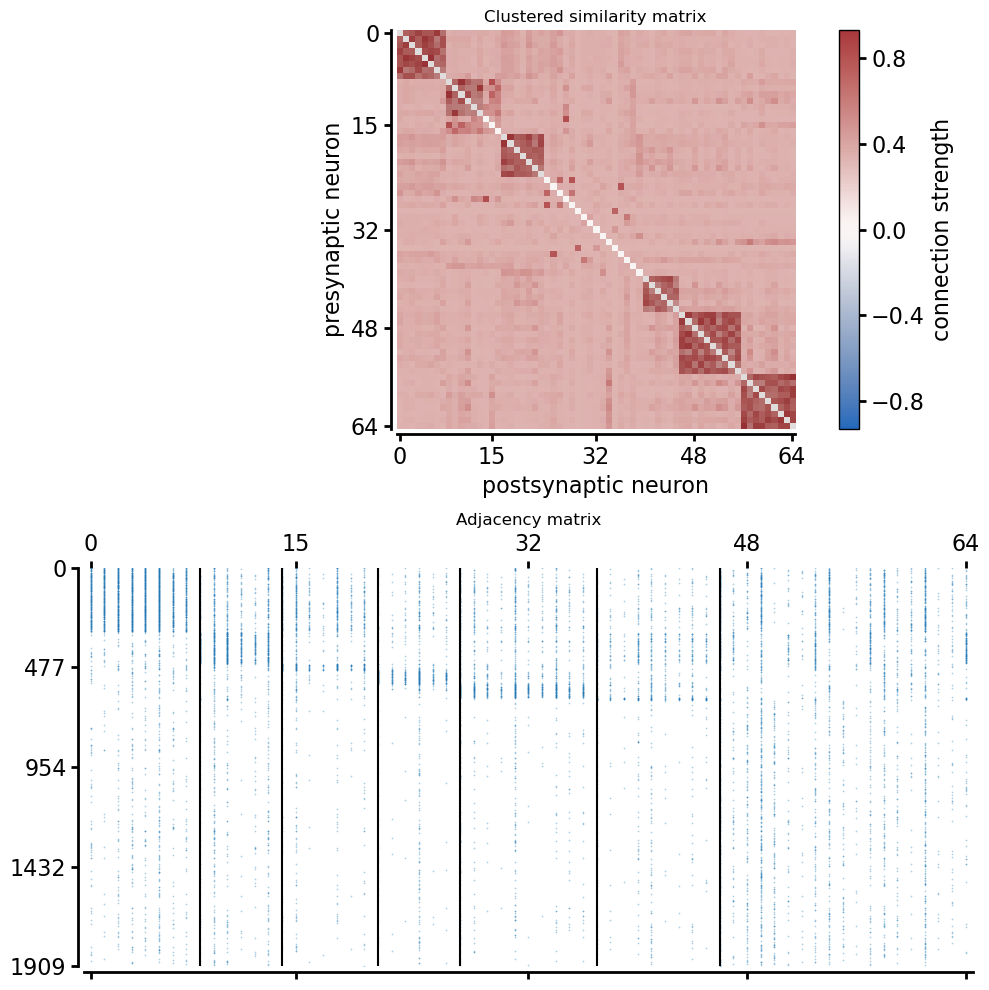

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Left: visualise similarity data
clustered_mat = clustered_cmatrix_1.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((clustered_mat.shape[0], clustered_mat.shape[1]))
# draw the boundaries between clusters
for cluster in index_clusters_1:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
_ = clustered_cmatrix_1.imshow(savefig=False, ax=axs[0], title="Clustered similarity matrix")
axs[0].imshow(mat, cmap="binary", alpha=0.1)

# Right: visualise the initial adjacency matrix where the rows are the premotor
# neurons and the columns are the motor neurons, and the premotor neurons are
# ordered according to the clusters, with vertical lines separating the clusters
sorted_motor_neurons = [n for cluster in uid_clusters_1 for n in cluster]
sorted_motor_neurons.extend(
    list(set(motor_neurons).difference(set(sorted_motor_neurons)))
    )
# sort premotor neurons: find the premotor neurons that project to at least 
# x% of the motor neurons in a given cluster, and sort them according to the
# clusters. Append the others at the end.
sorted_premotor_neurons_1 = []
for cluster in uid_clusters_1:
    to_add = cmatrix_1.list_neurons_upstream_set(cluster, ratio=0.5)
    sorted_premotor_neurons_1.extend(
        list(set(to_add).difference(set(sorted_premotor_neurons_1))) # avoid duplicates
        )
sorted_premotor_neurons_1.extend(
    list(set(premotor_neurons).difference(set(sorted_premotor_neurons_1))) # complete
    )

# restrict the adjacency matrix to the premotor neurons and the motor neurons
cmatrix_1.restrict_from_to(
    sorted_premotor_neurons_1,
    sorted_motor_neurons,
    input_type="uid",
    keep_initial_order=False,
    )
print(sorted_premotor_neurons_1)
lookup = cmatrix_1.get_lookup()
lookup.sort_values(by="row_index", inplace=True)
print(lookup)
_ = cmatrix_1.spy(savefig=False, ax=axs[1], title="Adjacency matrix")
sum_c = 0
for i in range(0, len(uid_clusters_1)):
    sum_c += len(index_clusters_1[i])
    axs[1].axvline(sum_c, color="black")
plt.tight_layout()

plt.show()